# Setup

Runs imports and performs unit tests

In [ ]:
from cmath import pi
import numpy as np
import numpy.typing as npt
from scipy import linalg
import matplotlib.pyplot as plt
from typing import Literal
from spin_state import *
from unit_test import test

In [5]:
test(0, 0, 0, 1)  # Align
test(0, 0, 0, 0, True)  # Cross
test(0, pi / 2, pi, 1, True)  # Crossed, half-waveplate on diagonal
test(0, -pi / 2, pi, 1, True)  # Crossed, half-waveplate on anti-diagonal
test(pi / 2, 0, pi / 2, 0.25)  # Diagonal, QWP.


# Double Waveplate Test
Simulating the use of two QWP to emulate a single HWP. 

Setup consists of fixed polarizer and analyzer, and two rotating QWP. 

100%|██████████| 361/361 [00:45<00:00,  8.02it/s]


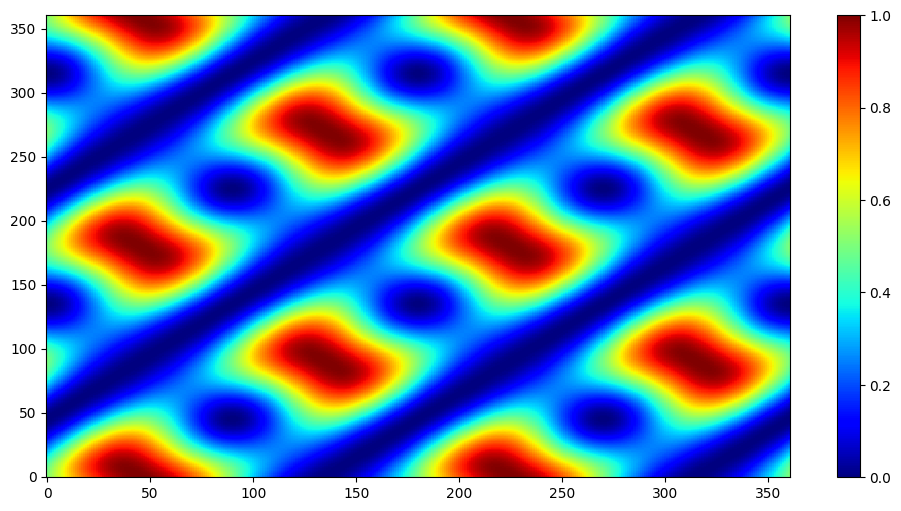

In [80]:
from tqdm import tqdm

angles_1 = np.arange(0, 361, 1)
angles_2 = np.arange(0, 361, 1)

laser_input = SpinStateFromAngle(pi / 2, 0).spin # type: ignore
polarizer = Polarizer(pi / 2, 0).operator
analyzer = Polarizer(pi / 2, pi).operator

intensity = []

for angle_1 in tqdm(angles_1):
    for angle_2 in angles_2:
        waveplate_1 = Waveplate(2*np.radians(angle_1+45), pi / 2).operator
        waveplate_2 = Waveplate(2*np.radians(angle_2), pi / 2).operator

        final_state = SpinState(
            analyzer @ waveplate_2 @ waveplate_1 @ polarizer @ laser_input
        )
        intensity.append(final_state.intensity)
        

intensity = np.array(intensity).reshape(angles_1.size, angles_2.size)

fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
heatmap = ax.pcolormesh(angles_2, angles_1, intensity, cmap='jet', shading='nearest')
fig.colorbar(heatmap, ax=ax)
plt.show()

2.9975647915395824


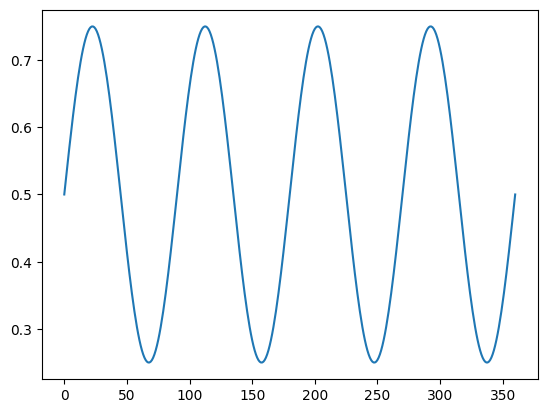

In [94]:
intensity = []
for angle_1 in angles_1:
        waveplate_1 = Waveplate(2*np.radians(angle_1+45), pi / 2).operator
        waveplate_2 = Waveplate(2*np.radians(angle_1), pi / 2).operator

        final_state = SpinState(
            analyzer @ waveplate_2 @ waveplate_1 @ polarizer @ laser_input
        )
        intensity.append(final_state.intensity)

plt.plot(intensity)
print(max(intensity)/min(intensity))

# Fork Grating

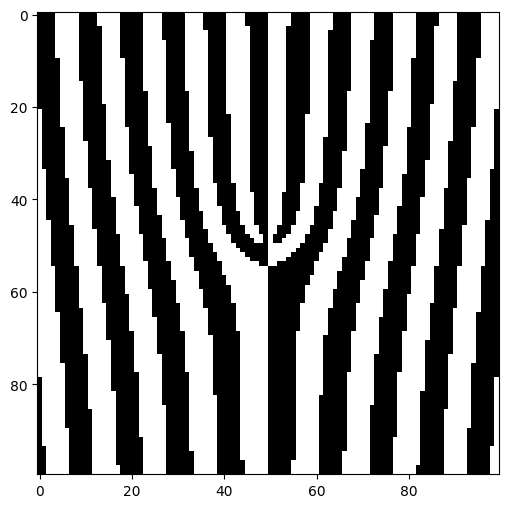

bool


In [11]:
def fork_grating(pg: float, l: int, shape: tuple[int, int] = (1920, 1080)) -> npt.NDArray[np.bool_]:
    """
    Function for generating a fork grating. 

    Args:
        pg: Period of the grating.
        l: Rotational mode number or OAM state number. 
            Also known as topological charge.
        shape: Size of the image holding the fork grating.
    """
    x = np.linspace(-shape[0]/2, shape[0]/2, shape[0])
    y = np.linspace(-shape[1]/2, shape[1]/2, shape[1])
    xv, yv = np.meshgrid(x, y)
    grating = np.zeros(shape)

    grating = np.cos(2*pi*xv/pg + l * np.arctan2(yv, xv)) > 0
    return grating


grating = fork_grating(10, 3, (100, 100))

plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(grating, cmap='Greys')


plt.show()


# OAM Simulation

In [5]:
%matplotlib ipympl 

from matplotlib.widgets import Slider, Button

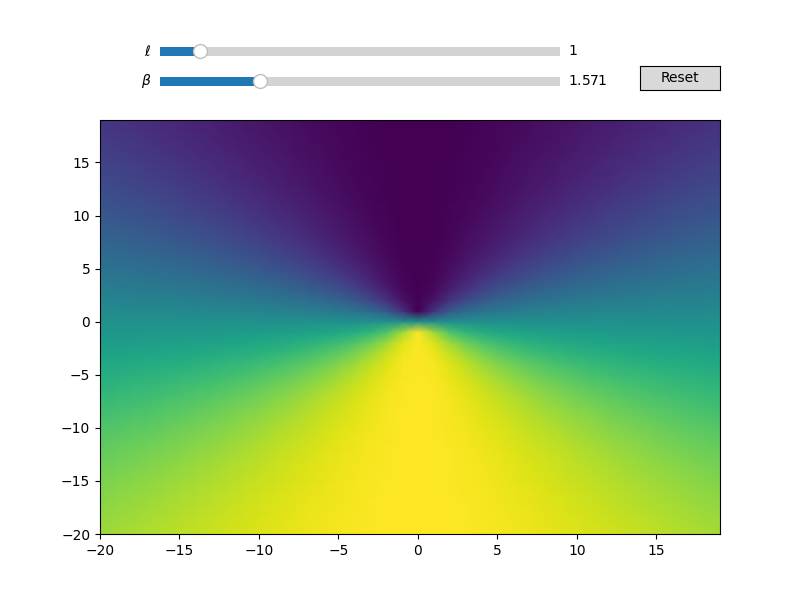

In [12]:
# Setup 
xmin = -20
xmax = 20
ymin = -20
ymax = 20

x = np.arange(xmin, xmax)
y = np.arange(ymin, ymax)

xx, yy = np.meshgrid(x, y)
phi: npt.NDArray[np.float64] = np.arctan2(yy, xx)


def oam_simulation(l: int, beta: float) -> npt.NDArray[np.float64]:

    slm = SLM(l, phi)

    laser_input = SpinStateFromAngle(pi / 2, 0).spin
    polarizer = (Polarizer(pi / 2, pi / 2).operator) # Diagonal
    analyzer = (Polarizer(pi / 2, 3 * pi / 2).operator) # Anti-Diagonal
    sample = (Waveplate(0, beta).operator)
    intensity = np.empty(xx.shape)

    for i in np.arange(xx.shape[0]):
        for j in np.arange(xx.shape[1]):
            psi_1 = (polarizer @ laser_input)
            psi_2 = (slm.operator[..., i, j] @ psi_1)
            psi_3 = (sample @ psi_2) 
            psi_4 = (analyzer @ psi_3)
            final_state = psi_4
            spin = SpinState(final_state)
            intensity[i, j] = spin.intensity
    
    return intensity

# Define initial parameters
init_l = 1 
init_b = pi / 2 

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(8, 6))
color_map = ax.pcolormesh(xx, yy, oam_simulation(init_l, init_b), shading='gouraud')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(top=0.8)

# Make a horizontal slider to control the frequency.
ax_l = fig.add_axes([0.2, 0.9, 0.5, 0.03])
slider_l = Slider(
    ax=ax_l,
    label=r"$\ell$ ",
    valmin=0,
    valmax=10,
    valfmt="%0.0f", # restricts to int
    valstep=np.arange(11), # discrete values only
    valinit=init_l,

)

ax_b = fig.add_axes([0.2, 0.85, 0.5, 0.03])
slider_b = Slider(
    ax=ax_b,
    label=r"$\beta$ ",
    valmin=0,
    valmax=2 * pi,
    valstep=np.arange(0, 8 * pi, pi / 4), # discrete values only
    valinit=init_b,
)

# The function to be called anytime a slider's value changes
def update(val):
    color_map.set_array(oam_simulation(slider_l.val, slider_b.val))
    fig.canvas.draw_idle()


# register the update function with each slider
slider_l.on_changed(update)
slider_b.on_changed(update)


# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.85, 0.1, 0.04])
button = Button(resetax, "Reset", hovercolor="0.975")


def reset(event) -> None:
    slider_l.reset()
    slider_b.reset()


button.on_clicked(reset)

plt.show()


In [ ]:
# Setup
xmin = -20
xmax = 20
ymin = -20
ymax = 20

x = np.arange(xmin, xmax)
y = np.arange(ymin, ymax)

xx, yy = np.meshgrid(x, y)
phi = np.arctan2(yy, xx)


def oam_simulation(
    l: int, alpha: float, beta: float, theta_1: float, theta2: float
) -> npt.NDArray[np.float64]:
    laser_input = SpinStateFromAngle(pi / 2, 0).spin
    polarizer = Polarizer(pi / 2, theta_1).operator
    analyzer = Polarizer(pi / 2, theta2).operator
    sample = Waveplate(alpha, beta).operator

    # slm_1 = SLM(l, phi).operator
    # slm_2 = SLM(-l, phi).operator

    intensity = np.empty(xx.shape)

    for i in np.arange(xx.shape[0]):
        for j in np.arange(xx.shape[1]):
            # spin_input = (
            #     slm_1[..., i, j] @ polarizer @ laser_input
            # + slm_2[..., i, j] @ polarizer @ laser_input
            # )

            slm_superposition = np.array([
                [np.exp(1j * l * phi[i, j]), 0],
                [0, np.exp(-1j * l * phi[i, j])]
            ]) # type: ignore
            
            spin_input = slm_superposition @ polarizer @ laser_input
            final_state = analyzer @ sample @ spin_input
            spin = SpinState(final_state)
            intensity[i, j] = spin.intensity

    return intensity


# Define initial parameters
init_l = 1
init_a = 0
init_b = pi / 2
init_theta_1 = pi / 2
init_theta_2 = 3 * pi / 2

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(8, 6))
color_map = ax.pcolormesh(
    xx,
    yy,
    oam_simulation(init_l, init_a, init_b, init_theta_1, init_theta_2),
    shading="gouraud",
    vmax=.5
)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(top=0.7)

# Make a horizontal slider to control the frequency.
ax_l = fig.add_axes([0.2, 0.9, 0.5, 0.03])
slider_l = Slider(
    ax=ax_l,
    label=r"$\ell$ OAM number",
    valmin=0,
    valmax=10,
    valfmt="%0.0f",  # restricts to int
    valstep=np.arange(11),  # discrete values only
    valinit=init_l,
)
ax_a = fig.add_axes([0.2, 0.85, 0.5, 0.03])
slider_a = Slider(
    ax=ax_a,
    label=r"$\alpha$ Birefringence Axis",
    valmin=0,
    valmax=2 * pi,
    # valstep=np.arange(0, 2 * pi, pi / 4), # discrete values only
    valinit=init_a,
)
ax_b = fig.add_axes([0.2, 0.80, 0.5, 0.03])
slider_b = Slider(
    ax=ax_b,
    label=r"$\beta$ Retardance",
    valmin=0,
    valmax=2 * pi,
    # valstep=np.arange(0, 8 * pi, pi / 4),  # discrete values only
    valinit=init_b,
)
ax_theta_1 = fig.add_axes([0.2, 0.75, 0.5, 0.03])
slider_theta_1 = Slider(
    ax=ax_theta_1,
    label=r"$\theta$ Polarizer angle",
    valmin=0,
    valmax=2 * pi,
    valinit=init_theta_1,
)
ax_theta_2 = fig.add_axes([0.2, 0.7, 0.5, 0.03])
slider_theta_2 = Slider(
    ax=ax_theta_2,
    label=r"$\theta$ Analyzer angle",
    valmin=0,
    valmax=2 * pi,
    valinit=init_theta_2,
)


# The function to be called anytime a slider's value changes
def update(val):
    color_map.set_array(
        oam_simulation(
            slider_l.val,
            slider_a.val,
            slider_b.val,
            slider_theta_1.val,
            slider_theta_2.val,
        )
    )
    fig.canvas.draw_idle()


# register the update function with each slider
slider_l.on_changed(update)
slider_a.on_changed(update)
slider_b.on_changed(update)
slider_theta_1.on_changed(update)
slider_theta_2.on_changed(update)


# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.85, 0.1, 0.04])
button = Button(resetax, "Reset", hovercolor="0.975")


def reset(event) -> None:
    slider_l.reset()
    slider_a.reset()
    slider_b.reset()
    slider_theta_1.reset()
    slider_theta_2.reset()


button.on_clicked(reset)

plt.colorbar(color_map)
plt.show()


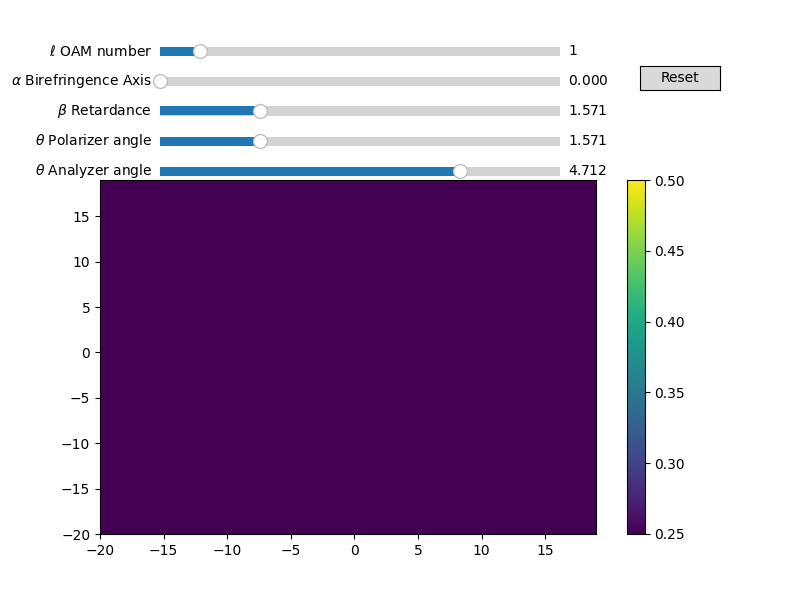

In [18]:
# Setup
xmin = -20
xmax = 20
ymin = -20
ymax = 20

x = np.arange(xmin, xmax)
y = np.arange(ymin, ymax)

xx, yy = np.meshgrid(x, y)
phi = np.arctan2(yy, xx)


def oam_simulation(
    l: int, alpha: float, beta: float, theta_1: float, theta2: float
) -> npt.NDArray[np.float64]:
    laser_input = SpinStateFromAngle(pi / 2, 0).spin
    polarizer = Polarizer(pi / 2, theta_1).operator
    analyzer = Polarizer(pi / 2, theta2).operator
    sample = Waveplate(alpha, beta).operator

    slm_1 = SLM(l, phi).operator
    slm_2 = SLM(-l, phi).operator

    intensity = np.empty(xx.shape)

    for i in np.arange(xx.shape[0]):
        for j in np.arange(xx.shape[1]):
            spin_input = slm_1[..., i, j] @ polarizer @ laser_input
            
            final_state = analyzer @ slm_2[..., i, j] @ sample @ spin_input
            spin = SpinState(final_state)
            intensity[i, j] = spin.intensity

    return intensity


# Define initial parameters
init_l = 1
init_a = 0
init_b = pi / 2
init_theta_1 = pi / 2
init_theta_2 = 3 * pi / 2

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(8, 6))
color_map = ax.pcolormesh(
    xx,
    yy,
    oam_simulation(init_l, init_a, init_b, init_theta_1, init_theta_2),
    shading="gouraud",
    vmax=.5
)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(top=0.7)

# Make a horizontal slider to control the frequency.
ax_l = fig.add_axes([0.2, 0.9, 0.5, 0.03])
slider_l = Slider(
    ax=ax_l,
    label=r"$\ell$ OAM number",
    valmin=0,
    valmax=10,
    valfmt="%0.0f",  # restricts to int
    valstep=np.arange(11),  # discrete values only
    valinit=init_l,
)
ax_a = fig.add_axes([0.2, 0.85, 0.5, 0.03])
slider_a = Slider(
    ax=ax_a,
    label=r"$\alpha$ Birefringence Axis",
    valmin=0,
    valmax=2 * pi,
    # valstep=np.arange(0, 2 * pi, pi / 4), # discrete values only
    valinit=init_a,
)
ax_b = fig.add_axes([0.2, 0.80, 0.5, 0.03])
slider_b = Slider(
    ax=ax_b,
    label=r"$\beta$ Retardance",
    valmin=0,
    valmax=2 * pi,
    # valstep=np.arange(0, 8 * pi, pi / 4),  # discrete values only
    valinit=init_b,
)
ax_theta_1 = fig.add_axes([0.2, 0.75, 0.5, 0.03])
slider_theta_1 = Slider(
    ax=ax_theta_1,
    label=r"$\theta$ Polarizer angle",
    valmin=0,
    valmax=2 * pi,
    valinit=init_theta_1,
)
ax_theta_2 = fig.add_axes([0.2, 0.7, 0.5, 0.03])
slider_theta_2 = Slider(
    ax=ax_theta_2,
    label=r"$\theta$ Analyzer angle",
    valmin=0,
    valmax=2 * pi,
    valinit=init_theta_2,
)


# The function to be called anytime a slider's value changes
def update(val):
    color_map.set_array(
        oam_simulation(
            slider_l.val,
            slider_a.val,
            slider_b.val,
            slider_theta_1.val,
            slider_theta_2.val,
        )
    )
    fig.canvas.draw_idle()


# register the update function with each slider
slider_l.on_changed(update)
slider_a.on_changed(update)
slider_b.on_changed(update)
slider_theta_1.on_changed(update)
slider_theta_2.on_changed(update)


# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.85, 0.1, 0.04])
button = Button(resetax, "Reset", hovercolor="0.975")


def reset(event) -> None:
    slider_l.reset()
    slider_a.reset()
    slider_b.reset()
    slider_theta_1.reset()
    slider_theta_2.reset()


button.on_clicked(reset)

plt.colorbar(color_map)
plt.show()
